In [1]:
import os
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

from src.training.config import *

DURATION = "duration"
TASK = "task_name"

df = pl.read_csv(os.path.join(DATA_FOLDER, f"{TRAIN_FILE_NAME}.csv")).to_pandas()

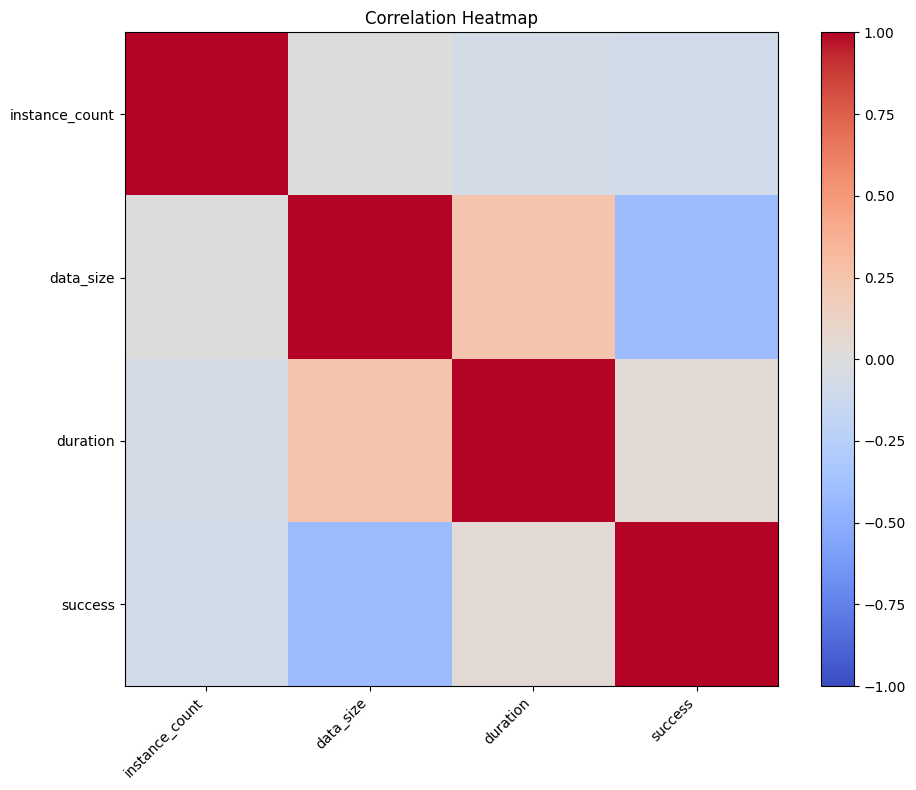

In [2]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(numeric_cols)))
ax.set_yticks(np.arange(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=45, ha="right")
ax.set_yticklabels(numeric_cols)

fig.colorbar(im, ax=ax)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

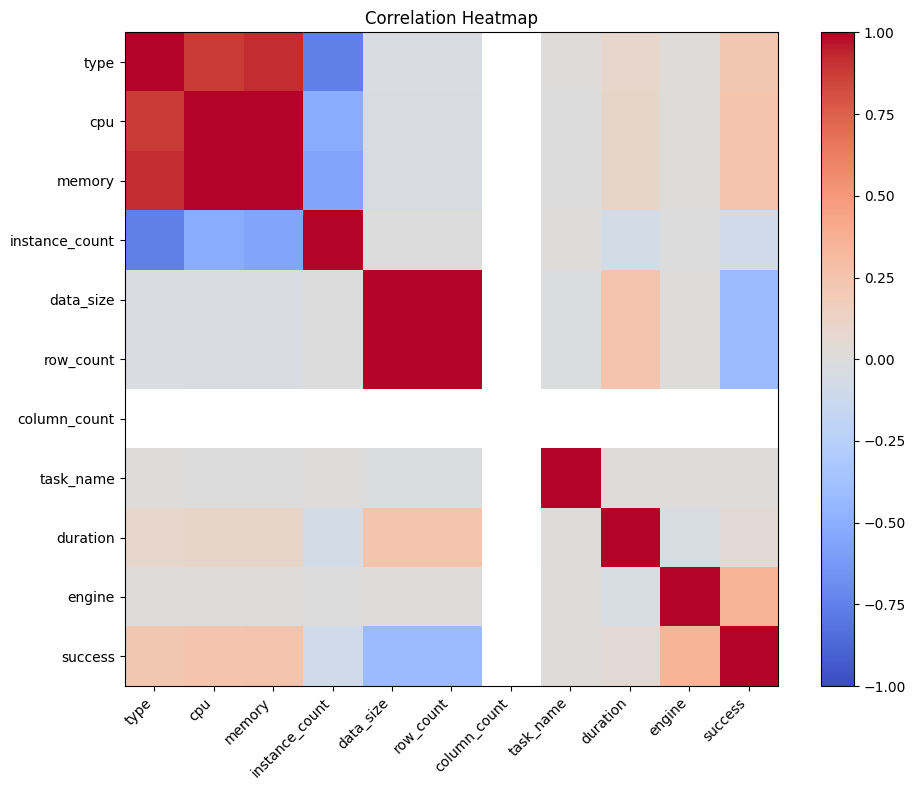

In [4]:
for col in df.columns:
    if df[col].dtype == object:
        df[col] = LabelEncoder().fit_transform(df[col])

corr = df.corr()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(df.columns)))
ax.set_yticks(np.arange(len(df.columns)))
ax.set_xticklabels(df.columns, rotation=45, ha="right")
ax.set_yticklabels(df.columns)

fig.colorbar(im, ax=ax)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


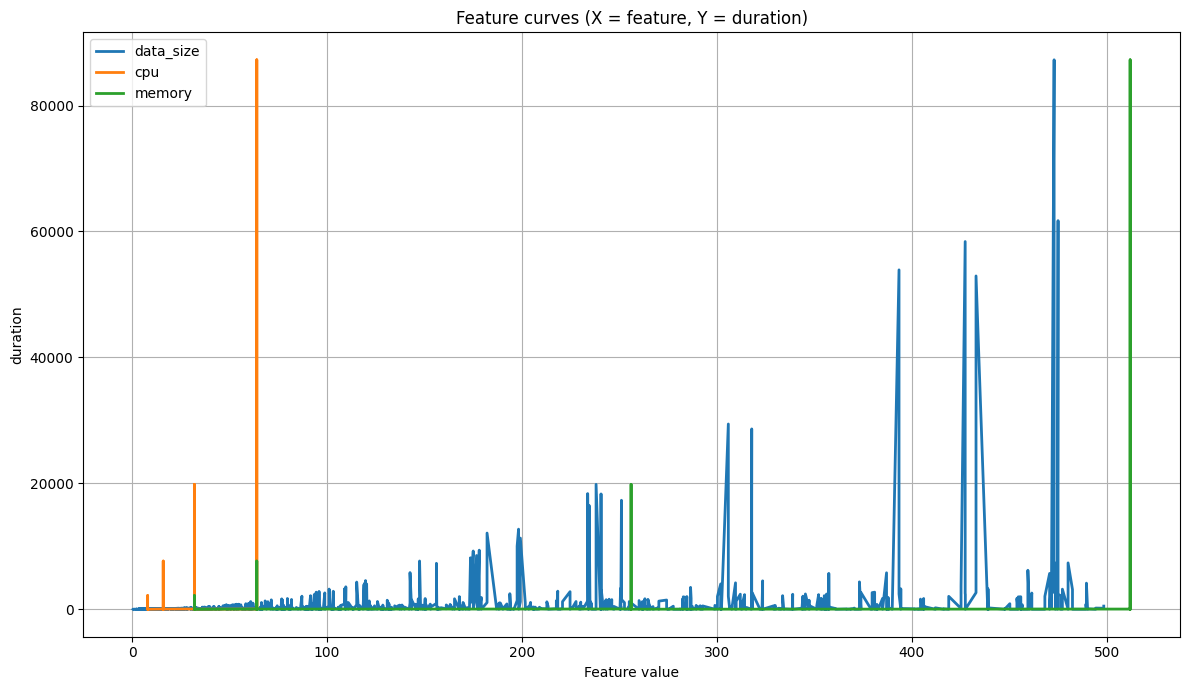

In [17]:

# le = LabelEncoder()
# df["task_name_enc"] = le.fit_transform(df["task_name"])
FEATURES = ['data_size', 'cpu', 'memory']

plt.figure(figsize=(12, 7))

for feature in FEATURES:
    df_sorted = df.sort_values(feature)
    plt.plot(
        df_sorted[feature].values,
        df_sorted[DURATION].values,
        label=feature,
        linewidth=2
    )

plt.xlabel("Feature value")
plt.ylabel(DURATION)
plt.title("Feature curves (X = feature, Y = duration)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Spark data analyzes

In [49]:
spark_df = (
    pl.read_csv(os.path.join(DATA_FOLDER, f"{TRAIN_FILE_NAME}.csv"))
    .filter(pl.col('engine') == 'spark')
    .select(SELECT_COLUMNS)
    .to_pandas()
)
# spark_df

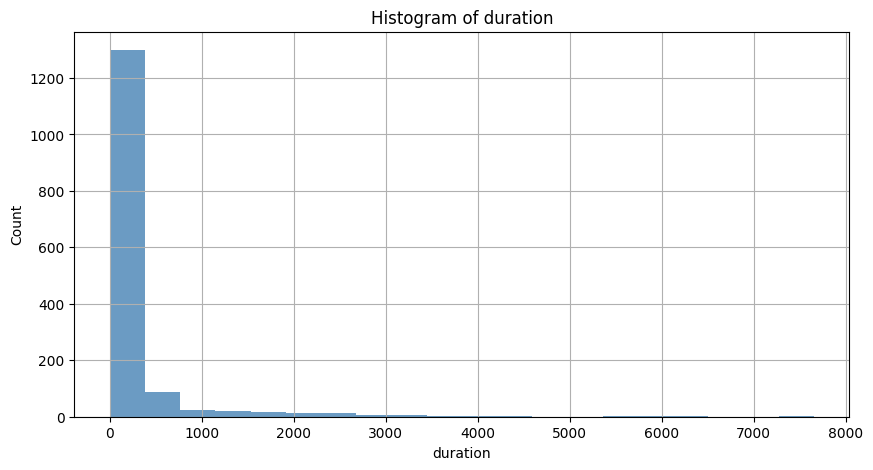

In [51]:
plt.figure(figsize=(10, 5))
plt.hist(spark_df[DURATION], bins=20, color="steelblue", alpha=0.8)
plt.xlabel(DURATION)
plt.ylabel("Count")
plt.title("Histogram of duration")
plt.grid(True)
plt.show()

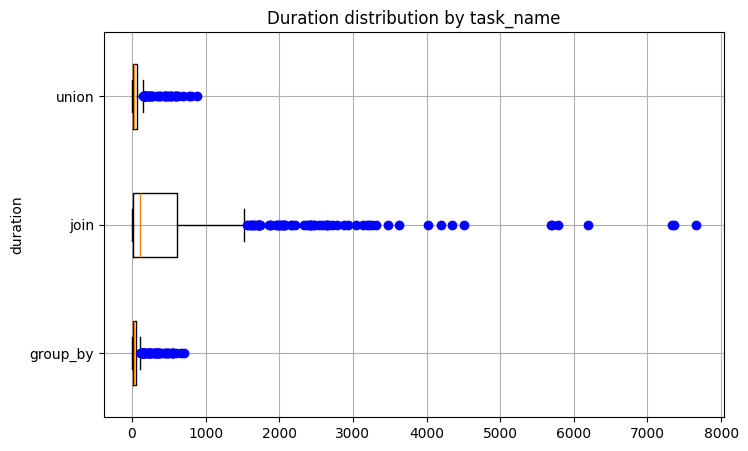

In [52]:
plt.figure(figsize=(8, 5))

tasks = spark_df[TASK].unique()
data = [spark_df[spark_df[TASK] == t][DURATION].values for t in tasks]

plt.boxplot(data, tick_labels=tasks, orientation='horizontal', widths=0.5, sym='b')
plt.title("Duration distribution by task_name")
plt.ylabel(DURATION)
plt.grid(True)
plt.show()

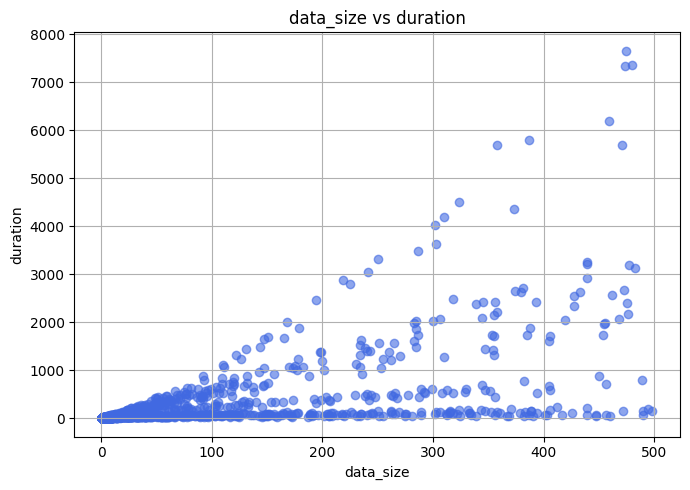

In [53]:
plt.figure(figsize=(7, 5))
plt.scatter(spark_df['data_size'], spark_df[DURATION], alpha=0.6, color="royalblue")
plt.xlabel('data_size')
plt.ylabel(DURATION)
plt.title(f"data_size vs {DURATION}")
plt.grid(True)
plt.tight_layout()
plt.show()

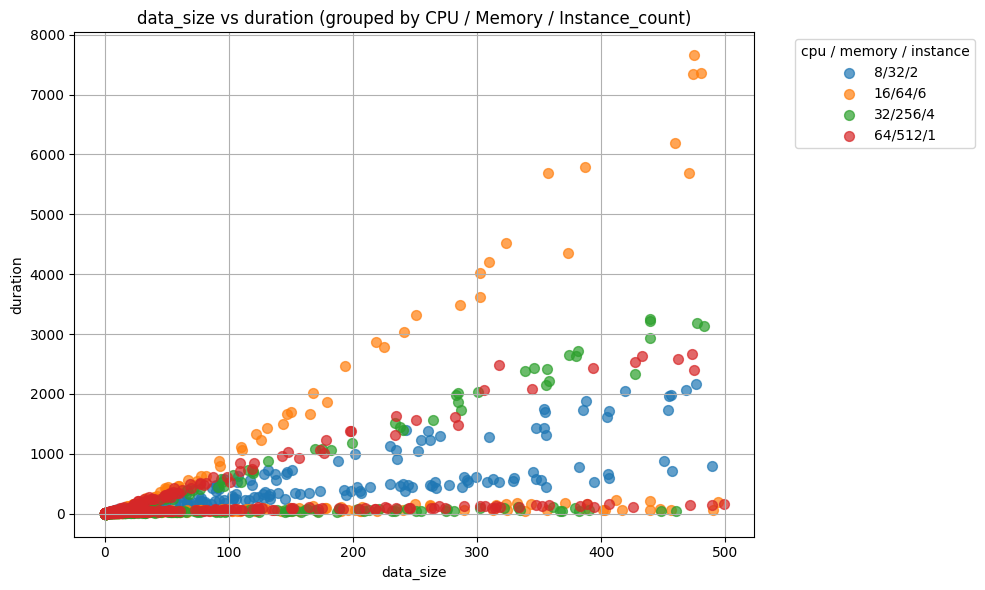

In [54]:
spark_df["group"] = (
    spark_df["cpu"].astype(str) + "/" +
    spark_df["memory"].astype(str) + "/" +
    spark_df["instance_count"].astype(str)
)

unique_groups = spark_df["group"].unique()

plt.figure(figsize=(10, 6))

for grp in unique_groups:
    grp_df = spark_df[spark_df["group"] == grp]
    plt.scatter(
        grp_df["data_size"],
        grp_df[DURATION],
        alpha=0.7,
        label=grp,
        s=50
    )

plt.xlabel("data_size")
plt.ylabel(DURATION)
plt.title("data_size vs duration (grouped by CPU / Memory / Instance_count)")
plt.grid(True)
plt.legend(title="cpu / memory / instance", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
